## Classification Task

In this part of the project, we investigate the factors that influence an athlete’s likelihood of winning a medal at the Olympic Games by building a classification model that predicts medal outcomes based on athlete and event characteristics. Our target variable is a medal, 1 = won and 0 = did not win.

For this, we use features such as:
- Athlete's Age and gender
- Event type (individual/team)
- Country-level info (historic medal counts/performance indicator)
- Experience (Number of previous Olympic participations)
- Year and location of the event (to account for temporal and regional effects)

The purpose of this classification analysis is to:
- Identify key factors that distinguish medal winners from non-winners
- Quantify the predictive power of athlete and contextual variables using machine learning
- Evaluate and compare different classification algorithms (e.g., logistic regression, random forest, XGBoost) in terms of predictive performance
- Gain insight into the profiles of successful athletes, potentially supporting training, scouting, and preparation efforts
- This analysis can provide support for sports analysts to assess medal potential before the Games, based on historical patterns


## Data Preparation

First, we check the target variable, which is Medal. Previously, we already defined, that 0 = no medal was won and 1 = a medal was won. Lets check how many entries there are for winners and non-winners.

In [1]:
#let's get our preporcessed df from first notebook
import pandas as pd
df = pd.read_pickle("data/preprocessed_data.pkl") #use pickle to keep the data types 

df["Medal_Won"] = df["Medal"].apply(lambda x: 1 if x > 0 else 0)
df["Medal_Won"].value_counts()

Medal_Won
0    230993
1     39774
Name: count, dtype: int64

Before we can start with the actual classification, some more feature engineering is needed.
We will rely on features engineered already in the clustering section:
- Total participants per sport (using ID), because this can be turned into a proxy for sport popularity, which may influence medal likelihood.
- Number of participating countries per sport, because this can be used as a competitiveness metric. Sports with more participating countries may be harder to medal in.
- Geographical distribution of medalists, because adding continent or region (from the NOC merge) might reveal geographic trends in success.


In [2]:
import numpy as np

athletes_per_sport = df.groupby('Sport')['ID'].nunique()
NOC_per_sport = df.groupby('Sport')['NOC'].nunique()
medals_per_sport = df[df['Medal'] != 0].groupby('Sport')['Medal'].count()
medals_region = df[df['Medal'] != 0].groupby(['Sport', 'region'])['Medal'].count().unstack(fill_value=0)

df['Decade'] = (df['Year'] // 10) * 10
participants_per_decade = df.groupby(['Sport', 'Decade'])['ID'].nunique().unstack(fill_value=0)

In [3]:
features = pd.concat([
    athletes_per_sport,
    NOC_per_sport,
    medals_per_sport,
    medals_region,
    participants_per_decade
], axis=1).fillna(0)

features.columns = ['Participants', 'NOCs', 'Medals'] + list(medals_region.columns) + list(participants_per_decade.columns)
features.describe()


Participants        NOCs       Medals  Afghanistan    Algeria  \
count     66.000000   66.000000    66.000000    66.000000  66.000000   
mean    2068.121212   60.378788   602.636364     0.030303   0.257576   
std     3214.372486   52.958551   805.784694     0.246183   1.339467   
min        1.000000    1.000000     1.000000     0.000000   0.000000   
25%      238.250000   16.000000    72.500000     0.000000   0.000000   
50%      830.500000   48.000000   211.000000     0.000000   0.000000   
75%     2731.750000   92.750000   968.000000     0.000000   0.000000   
max    22052.000000  226.000000  3969.000000     2.000000   9.000000   

       Argentina    Armenia   Australia     Austria  Azerbaijan  ...  \
count  66.000000  66.000000   66.000000   66.000000   66.000000  ...   
mean    4.151515   0.242424   20.439394    6.818182    0.666667  ...   
std    13.601179   1.301604   59.456546   15.965259    3.044962  ...   
min     0.000000   0.000000    0.000000    0.000000    0.000000  ...   
25%     0.000000   0.000000    0.000000    0.000000    0.000000  ...   
50%     0.000000   0.000000    0.000000    0.000000    0.000000  ...   
75%     1.000000   0.000000   10.000000    7.750000    0.000000  ...   
max    81.000000   8.000000  412.000000  114.000000   23.000000  ...   

              1920         1930        1940         1950         1960  \
count    66.000000    66.000000   66.000000    66.000000    66.000000   
mean    134.893939   105.287879   77.742424   133.318182   239.696970   
std     253.048924   200.139626  127.491938   236.891871   406.552673   
min       0.000000     0.000000    0.000000     0.000000     0.000000   
25%       0.000000     0.000000    0.000000     0.000000     0.000000   
50%      13.000000     0.000000    0.000000     0.000000     0.000000   
75%     181.250000   155.250000  134.250000   246.500000   369.500000   
max    1637.000000  1072.000000  744.000000  1514.000000  2528.000000   

              1970         1980         1990         2000         2010  
count    66.000000    66.000000    66.000000    66.000000    66.000000  
mean    203.363636   315.045455   318.181818   433.287879   336.681818  
std     327.020895   501.091407   461.501593   664.512031   498.554438  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000    15.500000    13.000000  
50%      32.000000   129.000000   199.000000   273.000000   233.000000  
75%     341.250000   533.250000   430.250000   576.500000   476.500000  
max    2029.000000  3261.000000  3201.000000  4699.000000  3592.000000  

[8 rows x 152 columns]

For me to being able to reuse the features engineered in the classification section, I have to do some adjustments. They have to be integrated into the althlete-level dataset instead of working with them on a sport-level. For this I will merge the aggregated sport-level features into athlete-level dataframe.

In [4]:
df = df.merge(features, left_on='Sport', right_index=True, how='left')
df.head()

ID           Name  Sex   Age  Height  Weight   Team  NOC  Year  Season  \
0     1      A Dijiang    0  24.0    1.80    80.0  China  CHN  1992       0   
1     2       A Lamusi    0  23.0    1.70    60.0  China  CHN  2012       0   
2   602  Abudoureheman    0  22.0    1.82    75.0  China  CHN  2000       0   
3  1463      Ai Linuer    0  25.0    1.60    62.0  China  CHN  2004       0   
4  1464      Ai Yanhan    1  14.0    1.68    54.0  China  CHN  2016       0   

   ... 1920 1930 1940  1950  1960  1970  1980  1990  2000  2010  
0  ...    0  199  287   421   468   352   569   445   686   485  
1  ...    0    0    0     0    72   259   531   709   894   651  
2  ...  423  259  205   385   773   579   981   640   765   504  
3  ...  451  253  219   368   713   619   824   652   792   572  
4  ...  412  346  249   504  1085   912  1264  1179  2164  1525  

[5 rows x 170 columns]

As the next step I will do some feature engineering specifically for the classification. I will engineer 
- Experience of an athlete (based on previous participations)
- Event type (individual/team)

In [5]:
df = df.sort_values(['ID', 'Year'])
df['Previous_Participations'] = df.groupby('ID').cumcount()

In [6]:
df = df[df['Event'].notna()]
df['Event_Type'] = df['Event'].apply(lambda x: 'Team' if 'Team' in x else 'Individual')


In [7]:
df = pd.get_dummies(df, columns=['Event_Type'], drop_first=True)

In [8]:
df.columns = df.columns.astype(str)
print(df.columns[df.columns.str.contains('Event')])

Index(['Event', 'Event_Type_Team'], dtype='object')


Now I also have to add sport-level features from the features data frame.

In [9]:
columns_to_merge = ['Participants', 'NOCs', 'Medals']
df = df.merge(features, left_on='Sport', right_index=True, how='left')

In [10]:
df.head()

ID                      Name  Sex   Age    Height     Weight  \
0      1                 A Dijiang    0  24.0  1.800000  80.000000   
1      2                  A Lamusi    0  23.0  1.700000  60.000000   
5141   3       Gunnar Nielsen Aaby    0  24.0  1.753443  70.709523   
5142   4      Edgar Lindenau Aabye    0  34.0  1.753443  70.709523   
8711   5  Christine Jacoba Aaftink    1  21.0  1.850000  82.000000   

                Team  NOC  Year  Season  ... 1920 1930 1940  1950 1960  1970  \
0              China  CHN  1992       0  ...    0  199  287   421  468   352   
1              China  CHN  2012       0  ...    0    0    0     0   72   259   
5141         Denmark  DEN  1920       0  ...  601  201  218   417  698   454   
5142  Denmark/Sweden  DEN  1900       0  ...   40    0    0     0    0     0   
8711     Netherlands  NED  1988       1  ...   61   75   68   121  284   201   

      1980  1990  2000  2010  
0      569   445   686   485  
1      531   709   894   651  
5141   752   654  1173   873  
5142     0     0     0     0  
8711   311   305   266   274  

[5 rows x 324 columns]

Now I would have to encode categorical variables. But first, I will check again which data types are present at the moment and which columns include data type 'object'.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 270767 entries, 0 to 222830
Columns: 324 entries, ID to 2010
dtypes: bool(1), float64(4), int64(312), object(7)
memory usage: 669.6+ MB


In [12]:
df.select_dtypes(include='object').columns

Index(['Name', 'Team', 'NOC', 'City', 'Sport', 'Event', 'region'], dtype='object')

Now i see, which variables are still objects in the dataframe. I will drop every column that includes the data type object due to different reasons:
- name contains unique identifiers for every athlete and have no power in contributing to predictive patterns.
- team seems important at first but it is highly specific. Also, usually every team is connected to the NOC. Since it has a very high number of unique entries, I will drop this column to avoid noise and for simplicity reasons.
- NOC is considered redundant since I already included the contry-level performance through the engineered feature.
- City refers to the host city of the olympics and doesn't provide any athlete-level information.
- Sport is really important but I already integrated sport-level characteristics—such as popularity, international reach, and medal distribution—through a separate aggregated features table.
- Event is a more granular version of Sport. Event-level context is already captured from derived features like Event_Type.

The only exception is 'region' since provides broad geographic information (e.g., Europe, Asia). Unlike the other object-type columns, it had a limited number of distinct values and potential predictive power, so it was retained and one-hot encoded.


In [13]:
cols_to_drop = ['Name', 'Team', 'City', 'Sport', 'Event', 'NOC'] 
df.drop(columns=cols_to_drop, inplace=True)

In [14]:
df = pd.get_dummies(df, columns=['region'], drop_first=True)

In [15]:
print(df.dtypes.value_counts())

int64      312
bool       208
float64      4
Name: count, dtype: int64


In [16]:
print(df.columns.tolist())

['ID', 'Sex', 'Age', 'Height', 'Weight', 'Year', 'Season', 'Medal', 'BMI', 'Medal_Won', 'Decade', 'Participants_x', 'NOCs_x', 'Medals_x', 'Afghanistan_x', 'Algeria_x', 'Argentina_x', 'Armenia_x', 'Australia_x', 'Austria_x', 'Azerbaijan_x', 'Bahamas_x', 'Bahrain_x', 'Barbados_x', 'Belarus_x', 'Belgium_x', 'Bermuda_x', 'Botswana_x', 'Brazil_x', 'Bulgaria_x', 'Burundi_x', 'Cameroon_x', 'Canada_x', 'Chile_x', 'China_x', 'Colombia_x', 'Costa Rica_x', 'Croatia_x', 'Cuba_x', 'Curacao_x', 'Cyprus_x', 'Czech Republic_x', 'Denmark_x', 'Djibouti_x', 'Dominican Republic_x', 'Ecuador_x', 'Egypt_x', 'Eritrea_x', 'Estonia_x', 'Ethiopia_x', 'Fiji_x', 'Finland_x', 'France_x', 'Gabon_x', 'Georgia_x', 'Germany_x', 'Ghana_x', 'Greece_x', 'Grenada_x', 'Guatemala_x', 'Guyana_x', 'Haiti_x', 'Hungary_x', 'Iceland_x', 'India_x', 'Individual Olympic Athletes_x', 'Indonesia_x', 'Iran_x', 'Iraq_x', 'Ireland_x', 'Israel_x', 'Italy_x', 'Ivory Coast_x', 'Jamaica_x', 'Japan_x', 'Jordan_x', 'Kazakhstan_x', 'Kenya_x', 

## Model Training and Evaluation


To prepare the dataset for modeling, I first define the target variable y, which indicates whether an athlete has won a medal. Then, I manually select a set of relevant predictor variables (X) based on the analysis before. These predictor variables are stored in the feature_cols list. Finally, I create the input feature matrix X by selecting only the chosen columns from the full dataset and verify the results

In [17]:
from sklearn.model_selection import train_test_split
import pandas as pd

y = df['Medal_Won']

feature_cols = [
    'Age', 'Previous_Participations', 'Participants_x', 'NOCs_x', 'Medals_x',
    'Sex', 'Event_Type_Team'
] + [
    col for col in df.columns
    if str(col).startswith('region_')
]

X = df[feature_cols]

print(f"X-Shape: {X.shape}")
print(f"Y-Shape: {y.shape}")


X-Shape: (270767, 214)
Y-Shape: (270767,)


The results show me, that I have 269,382 athlete records which equals the number of rows and each athlete (row) is represented by 214 feature columns. As the next step, I can now split my data into training and testing sets.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Now I will train a simple baseline model and check the results afterwards. Because the dataset is quite big, i have to scale my features before model training.

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Baseline Model: Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=5000)
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=5000)

In [21]:
print(y.value_counts())


Medal_Won
0    230993
1     39774
Name: count, dtype: int64


Once the training is done, I will continue with making predictions and evaluating the model. Just like in class, I will calculate the confusion matrix for the training data and evaluate the results.

In [22]:
y_pred = model.predict(X_test_scaled)


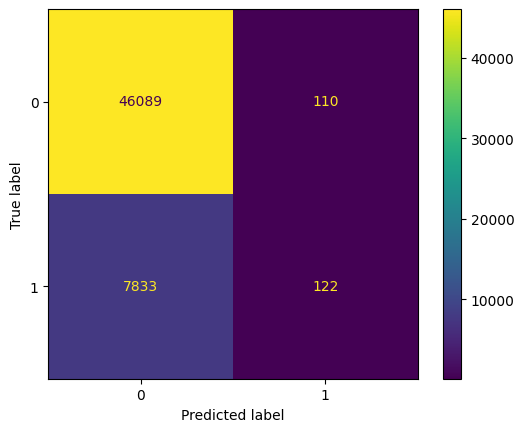

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     46199
           1       0.53      0.02      0.03      7955

    accuracy                           0.85     54154
   macro avg       0.69      0.51      0.48     54154
weighted avg       0.81      0.85      0.79     54154



In [23]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(classification_report(y_test, y_pred))


Text(0.5, 1.0, 'Class Balance: Medal_Won')

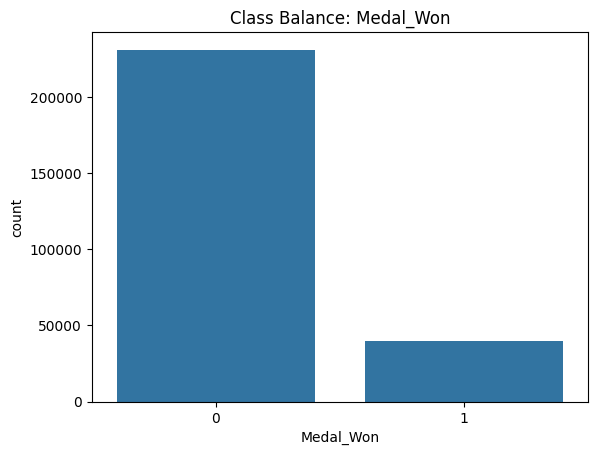

In [24]:
import seaborn as sns

sns.countplot(x=y)
plt.title("Class Balance: Medal_Won")


What I can see from the analysis is, that the logistic regression model reached an overall accuracy of 85%. But this result is influenced by an imbalance in the data, where most athletes did not win a medal. While the model reliably predicts non-medal winners, it struggles to identify those who won medals (represented by a recall of only 0.02 and an F1-score of 0.03, which is very low). This indicates that almost all actual medal winners are misclassified.
This shows that the model, in its current form, is not suitable for accurately classifying medal winners and further improvements are needed.

## Improved Model: Random Forest Classifier

After the logistic regression model struggled with the highly imbalanced data and correctly identifying very few medal winners, I will try a different approach: Random Forests. This model is particularly well-suited for imbalanced datasets because it uses an ensemble of decision trees, which helps reduce variance and overfitting.
Also, it applies a random selection of features at each tree split which increases model diversity and robustness. By setting class_weight="balanced", Random Forests can give more attention to the minority class (in my analysis: medal winners), with which the logistic regression had trouble in detecting. This combination often leads to better predictive performance, especially in classification tasks where one class is underrepresented.

After training the model, I will also use its feature importance scores to understand which variables contributing most to predicting the medal wins.

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight='balanced'  
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

Random Forest - accuracy on test set: 0.813
Random Forest - balanced accuracy on test set: 0.720
Random Forest - precision on test set: 0.406
Random Forest - recall on test set: 0.587
Random Forest - f1 score on test set: 0.480
Random Forest - roc_auc score on test set: 0.805


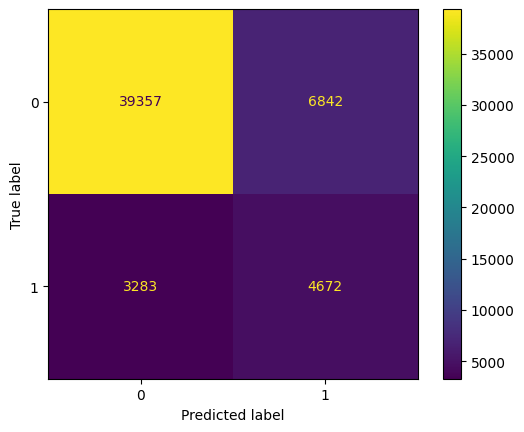

In [26]:
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print(f"Random Forest - accuracy on test set: {accuracy_score(y_test, rf_pred):.3f}")
print(f"Random Forest - balanced accuracy on test set: {balanced_accuracy_score(y_test, rf_pred):.3f}")
print(f"Random Forest - precision on test set: {precision_score(y_test, rf_pred):.3f}")
print(f"Random Forest - recall on test set: {recall_score(y_test, rf_pred):.3f}")
print(f"Random Forest - f1 score on test set: {f1_score(y_test, rf_pred):.3f}")
print(f"Random Forest - roc_auc score on test set: {roc_auc_score(y_test, rf_pred_proba):.3f}")

cm = confusion_matrix(y_test, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')


The Random Forest (RF) classifier significantly improved model performance. A reliable indicator is the overall accuracy of over 81%, which was acieved in this analysis. Most importantly, RF was able to detect medal winners (the minority class) with a much better recall and F1-score compared to the logistic regression before. This shows that RF can handle class imbalance more effectively and is a suitable choice for this classification task.
Next, I will plot the feature importance.

### Feature Importance

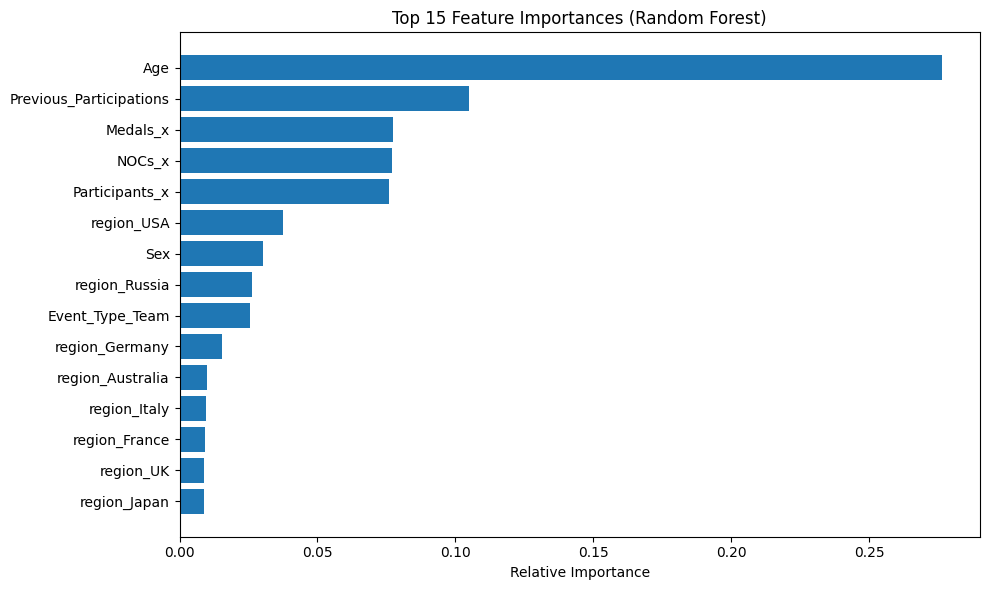

In [27]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf_model.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features
features = X_train.columns[indices]

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features)
plt.xlabel('Relative Importance')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


The feature importance analysis revealed that age and previous participations are the most influential factors in predicting medal success. This highlights the role of athlete experience and physical prime in winning a medal. Country-specific and event-related factors also played a meaningful role, offering interpretable insights into what characteristics contribute to athletic success.

## Conclusion of the Classification Analysis

For this analysis, I developed a classification model to predict medal winners based on various demographic and event-related features. After trying to do the analysis with a logistic regression approach, I selected a Random Forest Classifier with class balancing because it is more robust and able to handle imbalanced datasets (like we used here). The model achieved significantly better results than the logistic regression, with an overall accuracy of ~81%, a precision of 41% and a recall of 59% for the minority class of medal winners. This shows that, the model is better capable of identifying medal winners, but still misses some.

The confusion matrix and classification report demonstrate that, while the model performs well for the majority class (non-medal winners), it is less accurate for the minority class (medal winners). However, this could be expected in an imbalanced dataset. Compared to logistic regression, the Random Forest classifier significantly showed improvements, especially in the identification of medal winners. Feature importance analysis showed that age, previous participation and country are the top predictors of medal success. This actually aligns with intuitive expectations.

Overall, the classification task was successful and in the end offered a solid performance and interpretability. This model could form the basis for further improvements, such as hyperparameter tuning or the addition of domain-specific features, in the prediction of athletic achievement.